In [333]:
import os
import numpy as np
import pandas as pd
import librosa
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import torch
import torch.nn as nn
from torchviz import make_dot
from torchsummary import summary

In [334]:
# data_dir="C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester 6/460j/final_project_data/fma_small"
# file_path="C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester 6/460j/final_project_data/fma_small/000/000002.mp3"
train_path = 'C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester6/460j/460jFinalProject/csvfiles/extracted_features_combined.csv'
# train_path = 'C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester6/460j/460jFinalProject/csvfiles/extracted_features_wav2vec.csv'
torch.manual_seed(42)


In [335]:
data_df=pd.read_csv(train_path, index_col=0)
# data_df=pd.read_csv(train_path)

In [336]:
display(data_df.head())

,0,1,2,3,4,5,6,7,8,9,...,1176,1177,1178,1179,1180,1181,1182,1183,1184,genre
track_id,,,,,,,,,,,,,,,,,,,,,
2,-122.713936,117.760094,-42.334183,38.061005,-23.012323,23.920383,-11.944865,13.687291,-7.294582,4.041143,...,0.000032,0.000033,0.000039,0.000048,0.000078,0.000110,0.000089,0.000050,0.000029,Hip-Hop
5,-162.232422,131.435989,-18.426781,51.631371,-15.444844,23.860094,-7.867664,10.686234,-0.314591,12.864646,...,0.000039,0.000041,0.000060,0.000092,0.000102,0.000146,0.000153,0.000072,0.000038,Hip-Hop
10,-75.631538,154.537613,-63.849487,22.506426,2.425359,10.459981,-13.007332,9.818939,-7.640783,3.136315,...,0.000056,0.000066,0.000069,0.000083,0.000095,0.000103,0.000103,0.000072,0.000058,Pop
140,-322.997864,133.684906,15.497437,54.755615,8.718211,37.022747,-2.116411,15.265619,6.175477,-2.599205,...,0.000041,0.000035,0.000031,0.000038,0.000050,0.000052,0.000034,0.000024,0.000022,Folk
141,-253.314560,157.769379,-6.081675,26.920168,6.813843,15.842272,-12.930041,10.373278,-0.609945,-8.300909,...,0.000029,0.000025,0.000026,0.000048,0.000095,0.000081,0.000036,0.000029,0.000023,Folk


In [337]:

X = StandardScaler().fit_transform(data_df.drop('genre', axis=1))
y = pd.factorize(data_df['genre'])[0]  # Convert genre to numerical labels


In [338]:
display(y)

array([0, 0, 1, ..., 1, 1, 0], dtype=int64)

In [339]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [340]:
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

X_train_tensor_rnn = X_train_tensor.unsqueeze(1).expand(-1, 10, -1)  # Shape becomes [batch_size, 1, num_features]
X_test_tensor_rnn = X_test_tensor.unsqueeze(1).expand(-1, 10, -1)  # Shape becomes [batch_size, 1, num_features]
train_dataset_rnn = TensorDataset(X_train_tensor_rnn, y_train_tensor)
test_dataset_rnn = TensorDataset(X_test_tensor_rnn, y_test_tensor)
train_loader_rnn = DataLoader(train_dataset_rnn, batch_size=128, shuffle=True)
test_loader_rnn = DataLoader(test_dataset_rnn, batch_size=128, shuffle=False)


In [341]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 2048),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),

            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128,out_features=output_dim)

        )
        
    def forward(self, x):
        return self.layers(x)


In [342]:
import torch.nn as nn

class CNN1D(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CNN1D, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=6, padding=8),  # Adjust padding if necessary
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(32, 128, kernel_size=6, padding=8),  # Adjust padding if necessary
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        # Calculate size of the flattened output after conv and pooling layers
        self.output_size = self._get_conv_output(input_dim)

        self.fc_layers = nn.Sequential(
            nn.Linear(self.output_size, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
        
    def _get_conv_output(self, input_dim):
        # Dummy input for calculating size
        input = torch.zeros(1, 1, input_dim)
        output = self.conv_layers(input)
        n_size = output.data.view(1, -1).size(1)
        return n_size

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc_layers(x)


In [343]:
class RNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=512, num_layers=8):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])  # Take the last time step
        return x

class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=512, num_layers=8):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x, (hn, cn) = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Take the last time step
        return x


In [344]:
class EnsembleModel(nn.Module):
    def __init__(self, mlp, cnn, rnn, lstm, output_dim):
        super(EnsembleModel, self).__init__()
        self.mlp = mlp
        self.cnn = cnn
        self.rnn = rnn
        self.lstm = lstm
        self.fc = nn.Linear(output_dim * 4, output_dim)  # Assuming each model outputs the class probabilities
    
    def forward(self, x):
        out_mlp = self.mlp(x)
        out_cnn = self.cnn(x)
        out_rnn = self.rnn(x.unsqueeze(1))  # Assume RNN/LSTM expects sequence data
        out_lstm = self.lstm(x.unsqueeze(1))
        
        # Concatenate along the feature dimension
        combined = torch.cat((out_mlp, out_cnn, out_rnn, out_lstm), dim=1)
        output = self.fc(combined)
        return output


In [345]:
input_size = X_train.shape[1]
num_classes = len(np.unique(y))

In [346]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def train_model(model, train_loader, test_loader, device, epochs=100,lr=0.0001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    accuracies = []  # List to store accuracy for each epoch

    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        total = correct = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        accuracies.append(accuracy)  # Store accuracy for this epoch

        print(f'Epoch {epoch+1}: Accuracy: {accuracy}%')

    # Plotting the accuracies
    plt.figure(figsize=(20, 5))
    plt.plot(range(1, epochs+1), accuracies, marker='o', linestyle='-')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.xticks(range(1, epochs+1))  # Ensure x-axis labels match epoch numbers
    plt.yticks(range(0, 101, 10))  # Setting y-axis labels from 0 to 100% with steps of 10%
    plt.show()

    return max(accuracies)  # Return the highest accuracy reached


Epoch 1: Accuracy: 39.05794080867028%
Epoch 2: Accuracy: 41.22551062942893%
Epoch 3: Accuracy: 46.39433097123801%
Epoch 4: Accuracy: 45.97749062109212%
Epoch 5: Accuracy: 46.22759483117966%
Epoch 6: Accuracy: 48.22842851187995%
Epoch 7: Accuracy: 48.27011254689454%
Epoch 8: Accuracy: 47.644852021675696%
Epoch 9: Accuracy: 43.80992080033347%
Epoch 10: Accuracy: 50.43768236765319%
Epoch 11: Accuracy: 48.93705710712797%
Epoch 12: Accuracy: 49.35389745727387%
Epoch 13: Accuracy: 49.85410587744894%
Epoch 14: Accuracy: 48.35348061692372%
Epoch 15: Accuracy: 50.31263026260942%
Epoch 16: Accuracy: 50.35431429762401%
Epoch 17: Accuracy: 49.6040016673614%
Epoch 18: Accuracy: 48.145060441850774%
Epoch 19: Accuracy: 50.06252605252188%
Epoch 20: Accuracy: 48.4368486869529%
Epoch 21: Accuracy: 50.64610254272613%
Epoch 22: Accuracy: 51.396415172988746%
Epoch 23: Accuracy: 52.27177990829512%
Epoch 24: Accuracy: 50.687786577740724%
Epoch 25: Accuracy: 51.60483534806169%
Epoch 26: Accuracy: 49.478949562

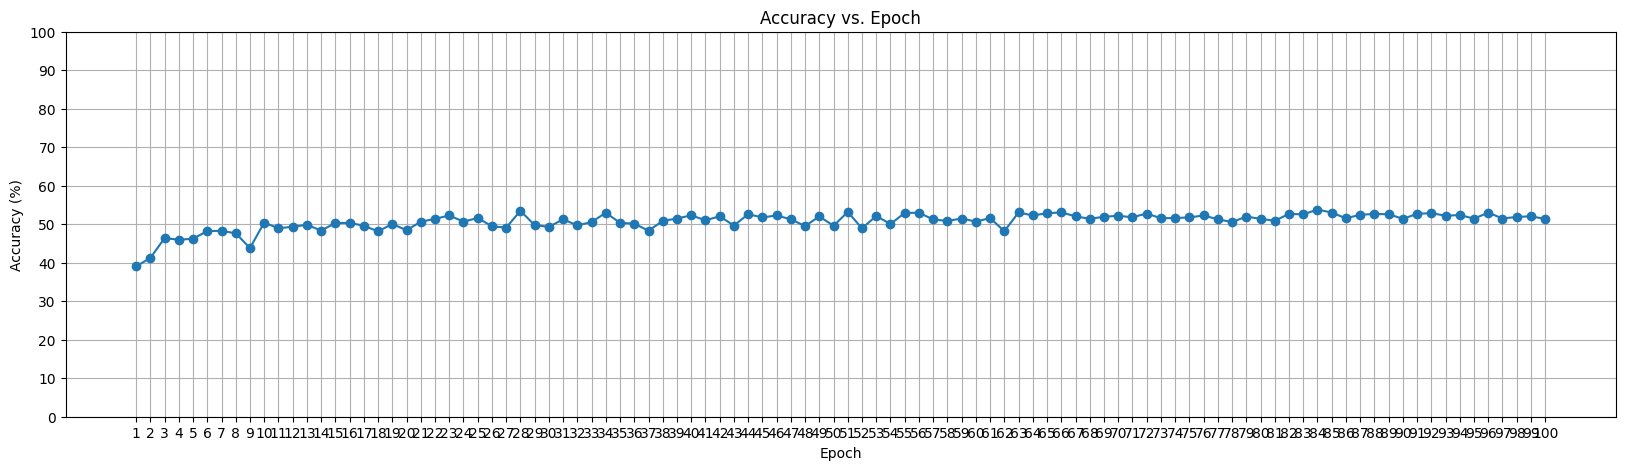

53.81408920383493

In [347]:
model_mlp=MLP(input_size,num_classes).to(device)
train_model(model_mlp, train_loader, test_loader, device)
# 54.127063531765884 entropy loss

In [348]:


# Assuming X_train.shape[1] is defined and device is defined
dummy_input = torch.zeros(1,X_train.shape[1]).to(device)  # Move dummy_input to the same device as the model
model_mlp.to(device)

# Visualize the model using torchviz
model_vis = make_dot(model_mlp(dummy_input), params=dict(model_mlp.named_parameters()))
model_vis.render("neural_network_visualization_mlp", format="png", view=True)

# Assuming num_classes is defined
summary(model_mlp, input_size=dummy_input.size()[1:])  # Correctly specifying input_size as a tuple


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1                 [-1, 1185]           2,370
            Linear-2                 [-1, 2048]       2,428,928
         LeakyReLU-3                 [-1, 2048]               0
           Dropout-4                 [-1, 2048]               0
            Linear-5                 [-1, 1024]       2,098,176
         LeakyReLU-6                 [-1, 1024]               0
           Dropout-7                 [-1, 1024]               0
            Linear-8                  [-1, 512]         524,800
       BatchNorm1d-9                  [-1, 512]           1,024
        LeakyReLU-10                  [-1, 512]               0
          Dropout-11                  [-1, 512]               0
           Linear-12                  [-1, 256]         131,328
      BatchNorm1d-13                  [-1, 256]             512
        LeakyReLU-14                  [

Epoch 1: Accuracy: 38.30762817840767%
Epoch 2: Accuracy: 41.89245518966236%
Epoch 3: Accuracy: 41.93413922467695%
Epoch 4: Accuracy: 44.935389745727385%
Epoch 5: Accuracy: 45.89412255106294%
Epoch 6: Accuracy: 46.31096290120884%
Epoch 7: Accuracy: 46.68611921634014%
Epoch 8: Accuracy: 46.97790746144227%
Epoch 9: Accuracy: 47.43643184660275%
Epoch 10: Accuracy: 48.47853272196749%
Epoch 11: Accuracy: 46.72780325135473%
Epoch 12: Accuracy: 48.603584827011254%
Epoch 13: Accuracy: 48.56190079199666%
Epoch 14: Accuracy: 47.76990412671947%
Epoch 15: Accuracy: 48.686952897040435%
Epoch 16: Accuracy: 49.97915798249271%
Epoch 17: Accuracy: 49.228845352230096%
Epoch 18: Accuracy: 50.14589412255106%
Epoch 19: Accuracy: 50.64610254272613%
Epoch 20: Accuracy: 49.43726552730304%
Epoch 21: Accuracy: 49.81242184243435%
Epoch 22: Accuracy: 50.270946227594834%
Epoch 23: Accuracy: 50.02084201750729%
Epoch 24: Accuracy: 49.93747394747812%
Epoch 25: Accuracy: 50.06252605252188%
Epoch 26: Accuracy: 50.270946

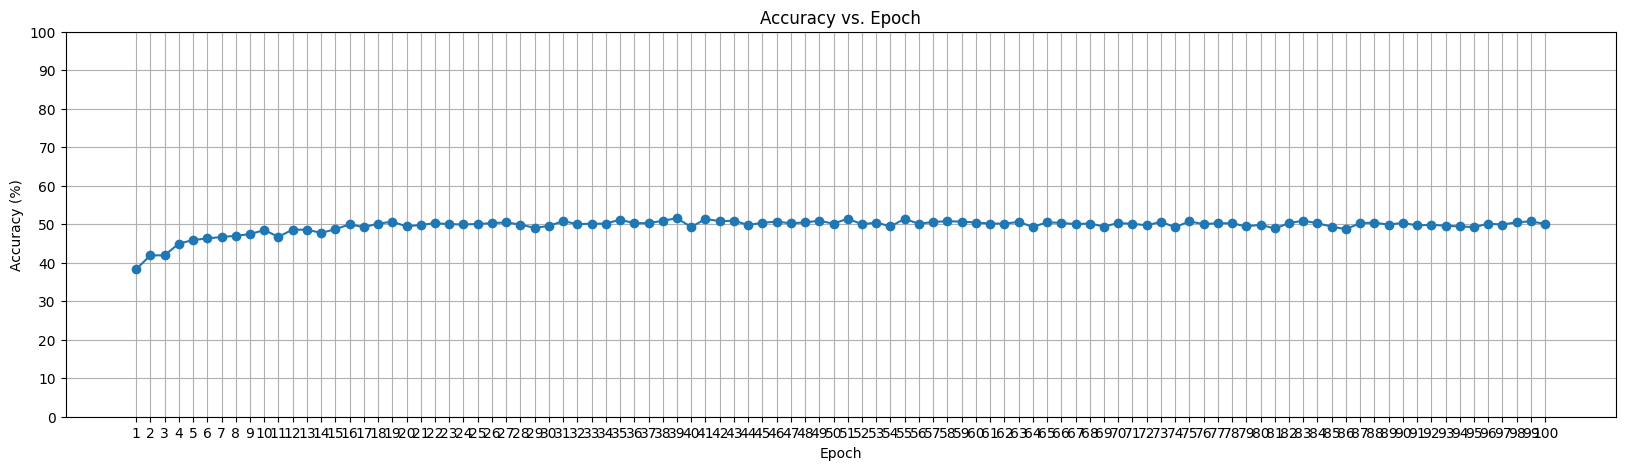

51.5631513130471

In [349]:
model_cnn=CNN1D(input_size,num_classes).to(device)
train_model(model_cnn, train_loader, test_loader, device) 
# 51.52576288144072 entropy loss

In [350]:


# Assuming X_train.shape[1] is defined and device is defined
dummy_input = torch.zeros(1,X_train.shape[1]).to(device)  # Move dummy_input to the same device as the model
model_cnn.to(device)

# Visualize the model using torchviz
model_vis = make_dot(model_cnn(dummy_input), params=dict(model_cnn.named_parameters()))
model_vis.render("neural_network_visualization_cnn", format="png", view=True)

# Assuming num_classes is defined
summary(model_cnn, input_size=dummy_input.size()[1:])  # Correctly specifying input_size as a tuple


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 32, 1196]             224
              ReLU-2             [-1, 32, 1196]               0
         MaxPool1d-3              [-1, 32, 598]               0
            Conv1d-4             [-1, 128, 609]          24,704
              ReLU-5             [-1, 128, 609]               0
         MaxPool1d-6             [-1, 128, 304]               0
            Linear-7                  [-1, 128]       4,980,864
              ReLU-8                  [-1, 128]               0
            Linear-9                    [-1, 8]           1,032
Total params: 5,006,824
Trainable params: 5,006,824
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 2.22
Params size (MB): 19.10
Estimated Total Size (MB): 21.32
-------------------------------------

Epoch 1: Accuracy: 31.179658190912882%
Epoch 2: Accuracy: 39.7665694039183%
Epoch 3: Accuracy: 43.434764485202166%
Epoch 4: Accuracy: 44.518549395581495%
Epoch 5: Accuracy: 44.393497290537724%
Epoch 6: Accuracy: 43.22634431012922%
Epoch 7: Accuracy: 45.477282200917045%
Epoch 8: Accuracy: 47.35306377657357%
Epoch 9: Accuracy: 48.10337640683618%
Epoch 10: Accuracy: 47.97832430179241%
Epoch 11: Accuracy: 47.47811588161734%
Epoch 12: Accuracy: 48.47853272196749%
Epoch 13: Accuracy: 46.14422676115048%
Epoch 14: Accuracy: 47.102959566486035%
Epoch 15: Accuracy: 48.97874114214256%
Epoch 16: Accuracy: 48.645268862025844%
Epoch 17: Accuracy: 49.39558149228846%
Epoch 18: Accuracy: 47.644852021675696%
Epoch 19: Accuracy: 45.68570237599%
Epoch 20: Accuracy: 48.8120050020842%
Epoch 21: Accuracy: 47.81158816173406%
Epoch 22: Accuracy: 48.020008336807%
Epoch 23: Accuracy: 48.22842851187995%
Epoch 24: Accuracy: 48.39516465193831%
Epoch 25: Accuracy: 48.47853272196749%
Epoch 26: Accuracy: 48.8536890370

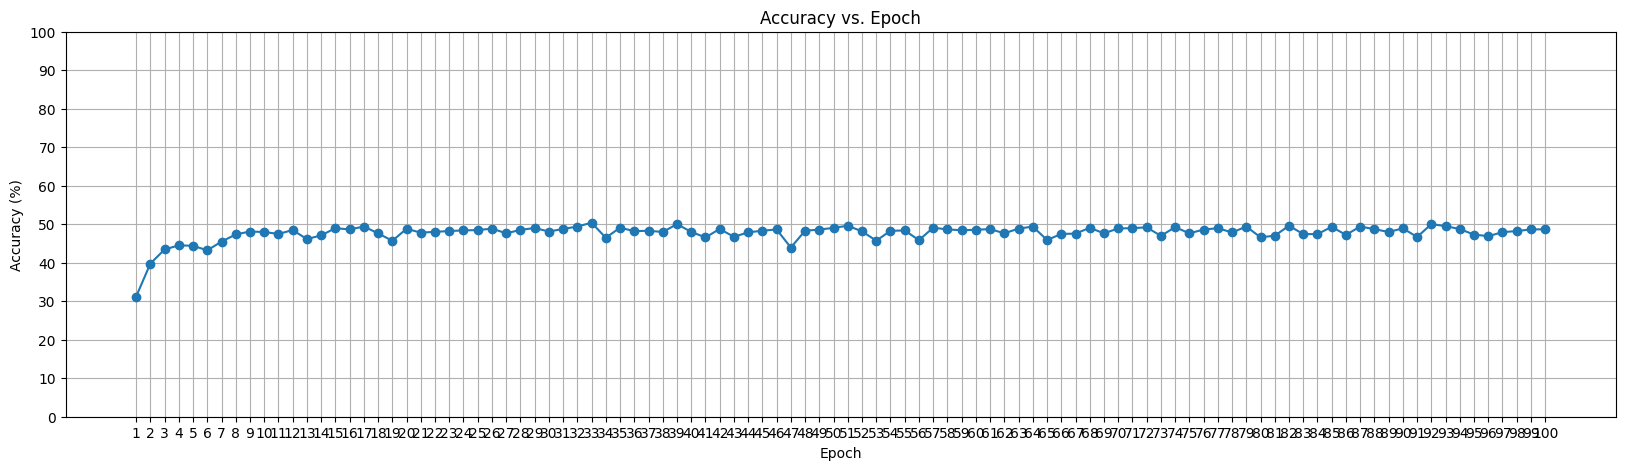

50.3959983326386

In [351]:
model_rnn=RNN(input_size,num_classes).to(device)
train_model(model_rnn, train_loader_rnn, test_loader_rnn, device) 
#50.17508754377189 entropy loss

In [352]:


# Assuming X_train.shape[1] is defined and device is defined
dummy_input = torch.zeros(1,1,X_train.shape[1]).to(device)  # Move dummy_input to the same device as the model
model_rnn.to(device)

# Visualize the model using torchviz
model_vis = make_dot(model_rnn(dummy_input), params=dict(model_rnn.named_parameters()))
model_vis.render("neural_network_visualization_rnn", format="png", view=True)

# Assuming num_classes is defined
summary(model_rnn, input_size=dummy_input.size()[1:])  # Correctly specifying input_size as a tuple


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 1, 512], [-1, 2, 512]]               0
            Linear-2                    [-1, 8]           4,104
Total params: 4,104
Trainable params: 4,104
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 4.00
Params size (MB): 0.02
Estimated Total Size (MB): 4.02
----------------------------------------------------------------


Epoch 1: Accuracy: 18.507711546477697%
Epoch 2: Accuracy: 24.05168820341809%
Epoch 3: Accuracy: 29.262192580241766%
Epoch 4: Accuracy: 31.471446436015007%
Epoch 5: Accuracy: 33.930804501875784%
Epoch 6: Accuracy: 33.72238432680283%
Epoch 7: Accuracy: 36.015006252605254%
Epoch 8: Accuracy: 37.098791162984575%
Epoch 9: Accuracy: 38.47436431846603%
Epoch 10: Accuracy: 39.182992913714045%
Epoch 11: Accuracy: 37.72405168820342%
Epoch 12: Accuracy: 39.05794080867028%
Epoch 13: Accuracy: 39.55814922884535%
Epoch 14: Accuracy: 40.641934139224674%
Epoch 15: Accuracy: 39.30804501875782%
Epoch 16: Accuracy: 40.725302209253854%
Epoch 17: Accuracy: 40.808670279283035%
Epoch 18: Accuracy: 40.308461859107965%
Epoch 19: Accuracy: 42.64276781992497%
Epoch 20: Accuracy: 43.14297624010004%
Epoch 21: Accuracy: 42.5177157148812%
Epoch 22: Accuracy: 43.05960817007086%
Epoch 23: Accuracy: 41.51729887453106%
Epoch 24: Accuracy: 41.267194664443515%
Epoch 25: Accuracy: 42.5177157148812%
Epoch 26: Accuracy: 43.2

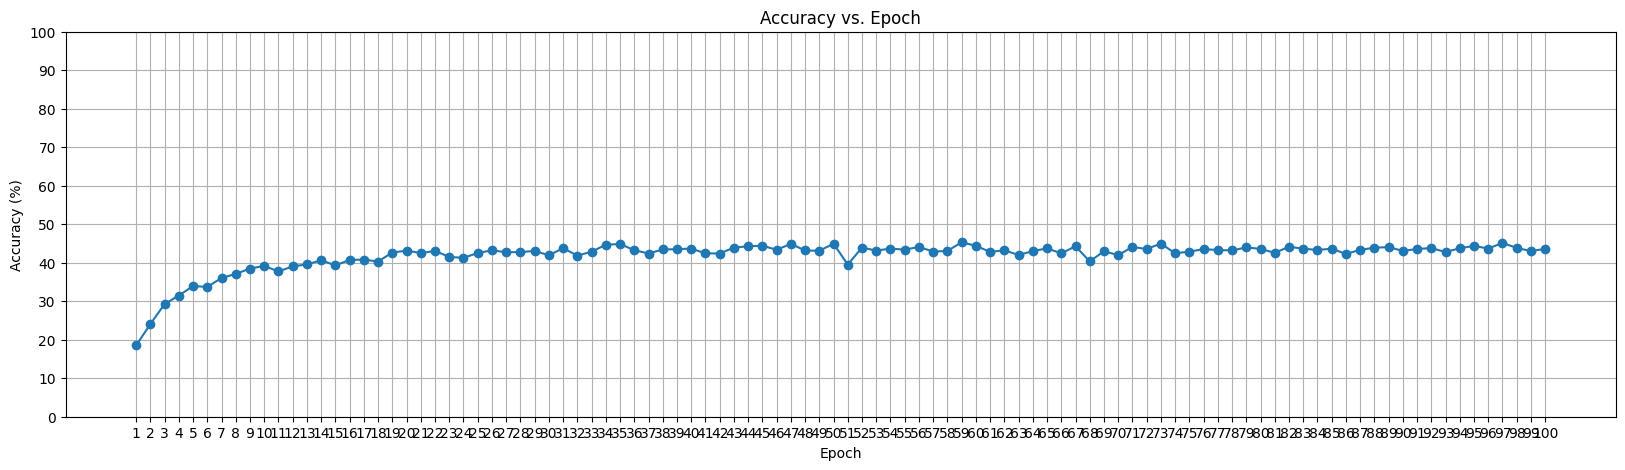

45.31054606085869

In [353]:
model_lstm=LSTM(input_size,num_classes).to(device)
train_model(model_lstm, train_loader_rnn, test_loader_rnn, device) 
#49.67483741870935 entropy loss

In [354]:


# # Assuming X_train.shape[1] is defined and device is defined
# dummy_input = torch.zeros(1,1,X_train.shape[1]).to(device)  # Move dummy_input to the same device as the model
# model_lstm.to(device)

# # Visualize the model using torchviz
# model_vis = make_dot(model_lstm(dummy_input), params=dict(model_lstm.named_parameters()))
# model_vis.render("neural_network_visualization_lstm", format="png", view=True)

# # Assuming num_classes is defined
# summary(model_lstm, input_size=dummy_input.size()[1:])  # Correctly specifying input_size as a tuple


Epoch 1: Accuracy: 35.514797832430176%
Epoch 2: Accuracy: 42.68445185493956%
Epoch 3: Accuracy: 44.935389745727385%
Epoch 4: Accuracy: 45.76907044601918%
Epoch 5: Accuracy: 46.76948728636932%
Epoch 6: Accuracy: 49.64568570237599%
Epoch 7: Accuracy: 49.02042517715715%
Epoch 8: Accuracy: 49.228845352230096%
Epoch 9: Accuracy: 49.35389745727387%
Epoch 10: Accuracy: 47.97832430179241%
Epoch 11: Accuracy: 50.64610254272613%
Epoch 12: Accuracy: 49.68736973739058%
Epoch 13: Accuracy: 50.229262192580244%
Epoch 14: Accuracy: 49.103793247186324%
Epoch 15: Accuracy: 49.93747394747812%
Epoch 16: Accuracy: 50.35431429762401%
Epoch 17: Accuracy: 50.60441850771154%
Epoch 18: Accuracy: 51.06294289287203%
Epoch 19: Accuracy: 51.979991663193%
Epoch 20: Accuracy: 48.770320967069615%
Epoch 21: Accuracy: 48.35348061692372%
Epoch 22: Accuracy: 50.31263026260942%
Epoch 23: Accuracy: 51.854939558149226%
Epoch 24: Accuracy: 51.77157148812005%
Epoch 25: Accuracy: 47.644852021675696%
Epoch 26: Accuracy: 49.60400

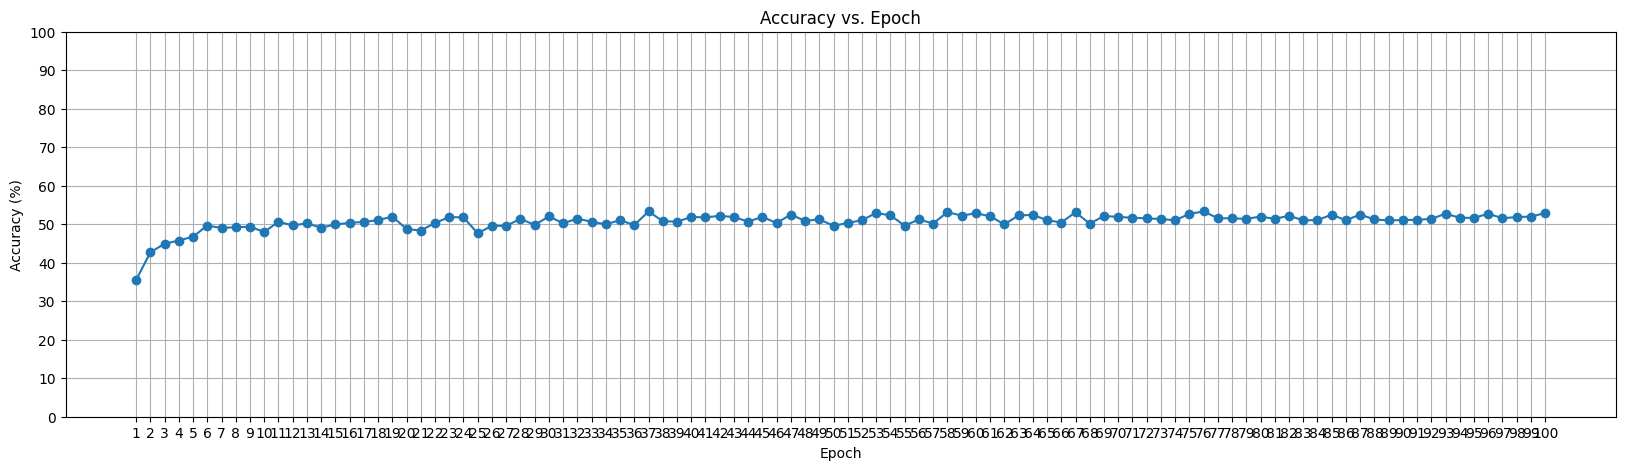

53.31388078365986

In [355]:
model_cnn_2=CNN1D(input_size,num_classes).to(device)
model_mlp_2=MLP(input_size,num_classes).to(device)
model_rnn_2=RNN(input_size,num_classes).to(device)
model_lstm_2=LSTM(input_size,num_classes).to(device)

model_ens=EnsembleModel(mlp=model_mlp_2,cnn=model_cnn_2,rnn=model_rnn_2,lstm=model_lstm_2,output_dim=num_classes).to(device)
train_model(model_ens, train_loader, test_loader, device)
# 53.62681340670335 accuracy entropy loss

In [356]:


# # Assuming X_train.shape[1] is defined and device is defined
# dummy_input = torch.zeros(1,X_train.shape[1]).to(device)  # Move dummy_input to the same device as the model
# model_ens.to(device)

# # Visualize the model using torchviz
# model_vis = make_dot(model_ens(dummy_input), params=dict(model_ens.named_parameters()))
# model_vis.render("neural_network_visualization_ens", format="png", view=True)

# # Assuming num_classes is defined
# summary(model_ens, input_size=dummy_input.size()[1:])  # Correctly specifying input_size as a tuple


In [357]:
def model_summary(model):
    print(model)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total trainable parameters: {total_params}')


In [358]:
# Print model summary
model_summary(model_ens)

EnsembleModel(
  (mlp): MLP(
    (layers): Sequential(
      (0): BatchNorm1d(1185, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=1185, out_features=2048, bias=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=2048, out_features=1024, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Dropout(p=0.1, inplace=False)
      (7): Linear(in_features=1024, out_features=512, bias=True)
      (8): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): LeakyReLU(negative_slope=0.01)
      (10): Dropout(p=0.1, inplace=False)
      (11): Linear(in_features=512, out_features=256, bias=True)
      (12): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): LeakyReLU(negative_slope=0.01)
      (14): Linear(in_features=256, out_features=128, bias=True)
      (15): BatchNorm1d(128, eps=1e-05, momentu

other dataset

In [359]:
train_path = 'C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester6/460j/460jFinalProject/csvfiles/extracted_features_wav2vec.csv'

data_df=pd.read_csv(train_path)

In [360]:

X = StandardScaler().fit_transform(data_df.drop('genre', axis=1))
y = pd.factorize(data_df['genre'])[0]  # Convert genre to numerical labels


In [361]:
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

X_train_tensor_rnn = X_train_tensor.unsqueeze(1).expand(-1, 10, -1)  # Shape becomes [batch_size, 1, num_features]
X_test_tensor_rnn = X_test_tensor.unsqueeze(1).expand(-1, 10, -1)  # Shape becomes [batch_size, 1, num_features]
train_dataset_rnn = TensorDataset(X_train_tensor_rnn, y_train_tensor)
test_dataset_rnn = TensorDataset(X_test_tensor_rnn, y_test_tensor)
train_loader_rnn = DataLoader(train_dataset_rnn, batch_size=128, shuffle=True)
test_loader_rnn = DataLoader(test_dataset_rnn, batch_size=128, shuffle=False)


In [362]:
input_size = X_train.shape[1]
num_classes = len(np.unique(y))

Epoch 1: Accuracy: 36.583333333333336%
Epoch 2: Accuracy: 40.833333333333336%
Epoch 3: Accuracy: 42.416666666666664%
Epoch 4: Accuracy: 43.708333333333336%
Epoch 5: Accuracy: 43.666666666666664%
Epoch 6: Accuracy: 44.333333333333336%
Epoch 7: Accuracy: 45.208333333333336%
Epoch 8: Accuracy: 42.958333333333336%
Epoch 9: Accuracy: 45.208333333333336%
Epoch 10: Accuracy: 44.583333333333336%
Epoch 11: Accuracy: 45.958333333333336%
Epoch 12: Accuracy: 44.291666666666664%
Epoch 13: Accuracy: 45.125%
Epoch 14: Accuracy: 44.375%
Epoch 15: Accuracy: 44.25%
Epoch 16: Accuracy: 43.125%
Epoch 17: Accuracy: 44.083333333333336%
Epoch 18: Accuracy: 43.916666666666664%
Epoch 19: Accuracy: 42.791666666666664%
Epoch 20: Accuracy: 44.291666666666664%
Epoch 21: Accuracy: 43.708333333333336%
Epoch 22: Accuracy: 44.333333333333336%
Epoch 23: Accuracy: 43.416666666666664%
Epoch 24: Accuracy: 44.458333333333336%
Epoch 25: Accuracy: 43.333333333333336%
Epoch 26: Accuracy: 44.416666666666664%
Epoch 27: Accuracy

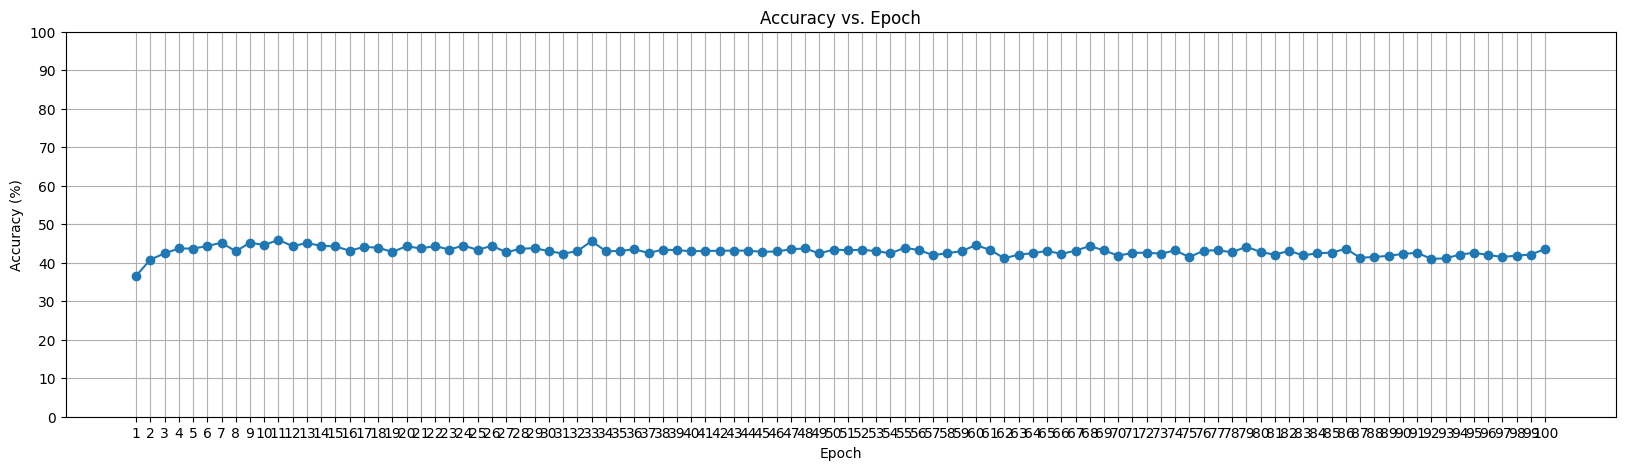

45.958333333333336

In [363]:
model_mlp=MLP(input_size,num_classes).to(device)
train_model(model_mlp, train_loader, test_loader, device)
# 54.127063531765884 entropy loss

In [364]:


# Assuming X_train.shape[1] is defined and device is defined
dummy_input = torch.zeros(1,X_train.shape[1]).to(device)  # Move dummy_input to the same device as the model
model_mlp.to(device)

# Visualize the model using torchviz
model_vis = make_dot(model_mlp(dummy_input), params=dict(model_mlp.named_parameters()))
model_vis.render("neural_network_visualization_secondary_mlp", format="png", view=True)

# Assuming num_classes is defined
summary(model_mlp, input_size=dummy_input.size()[1:])  # Correctly specifying input_size as a tuple


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1                  [-1, 769]           1,538
            Linear-2                 [-1, 2048]       1,576,960
         LeakyReLU-3                 [-1, 2048]               0
           Dropout-4                 [-1, 2048]               0
            Linear-5                 [-1, 1024]       2,098,176
         LeakyReLU-6                 [-1, 1024]               0
           Dropout-7                 [-1, 1024]               0
            Linear-8                  [-1, 512]         524,800
       BatchNorm1d-9                  [-1, 512]           1,024
        LeakyReLU-10                  [-1, 512]               0
          Dropout-11                  [-1, 512]               0
           Linear-12                  [-1, 256]         131,328
      BatchNorm1d-13                  [-1, 256]             512
        LeakyReLU-14                  [

Epoch 1: Accuracy: 35.666666666666664%
Epoch 2: Accuracy: 36.0%
Epoch 3: Accuracy: 40.958333333333336%
Epoch 4: Accuracy: 39.833333333333336%
Epoch 5: Accuracy: 42.083333333333336%
Epoch 6: Accuracy: 43.0%
Epoch 7: Accuracy: 44.458333333333336%
Epoch 8: Accuracy: 43.833333333333336%
Epoch 9: Accuracy: 45.958333333333336%
Epoch 10: Accuracy: 44.833333333333336%
Epoch 11: Accuracy: 44.291666666666664%
Epoch 12: Accuracy: 44.541666666666664%
Epoch 13: Accuracy: 44.958333333333336%
Epoch 14: Accuracy: 43.5%
Epoch 15: Accuracy: 45.791666666666664%
Epoch 16: Accuracy: 45.5%
Epoch 17: Accuracy: 44.416666666666664%
Epoch 18: Accuracy: 46.375%
Epoch 19: Accuracy: 46.125%
Epoch 20: Accuracy: 46.0%
Epoch 21: Accuracy: 44.083333333333336%
Epoch 22: Accuracy: 44.958333333333336%
Epoch 23: Accuracy: 45.416666666666664%
Epoch 24: Accuracy: 45.291666666666664%
Epoch 25: Accuracy: 44.833333333333336%
Epoch 26: Accuracy: 46.416666666666664%
Epoch 27: Accuracy: 44.125%
Epoch 28: Accuracy: 44.208333333333

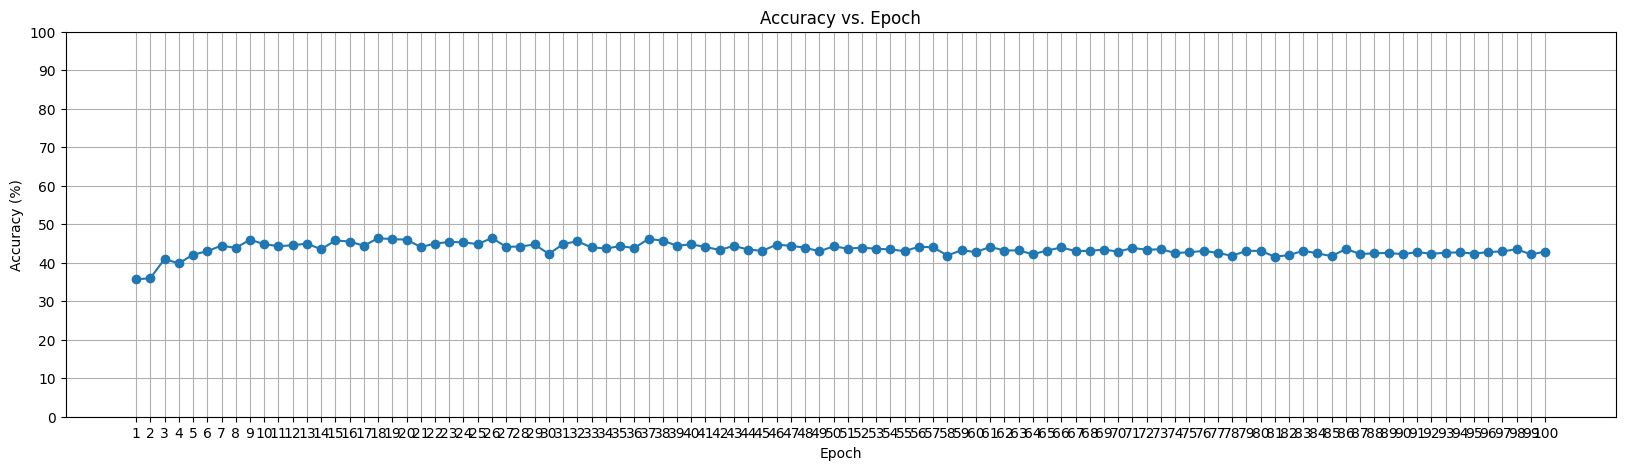

46.416666666666664

In [365]:
model_cnn=CNN1D(input_size,num_classes).to(device)
train_model(model_cnn, train_loader, test_loader, device) 
# 51.52576288144072 entropy loss

In [366]:


# Assuming X_train.shape[1] is defined and device is defined
dummy_input = torch.zeros(1,X_train.shape[1]).to(device)  # Move dummy_input to the same device as the model
model_cnn.to(device)

# Visualize the model using torchviz
model_vis = make_dot(model_cnn(dummy_input), params=dict(model_cnn.named_parameters()))
model_vis.render("neural_network_visualization_secondary_cnn", format="png", view=True)

# Assuming num_classes is defined
summary(model_cnn, input_size=dummy_input.size()[1:])  # Correctly specifying input_size as a tuple


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 780]             224
              ReLU-2              [-1, 32, 780]               0
         MaxPool1d-3              [-1, 32, 390]               0
            Conv1d-4             [-1, 128, 401]          24,704
              ReLU-5             [-1, 128, 401]               0
         MaxPool1d-6             [-1, 128, 200]               0
            Linear-7                  [-1, 128]       3,276,928
              ReLU-8                  [-1, 128]               0
            Linear-9                    [-1, 8]           1,032
Total params: 3,302,888
Trainable params: 3,302,888
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.46
Params size (MB): 12.60
Estimated Total Size (MB): 14.06
-------------------------------------

Epoch 1: Accuracy: 32.583333333333336%
Epoch 2: Accuracy: 37.375%
Epoch 3: Accuracy: 42.875%
Epoch 4: Accuracy: 39.916666666666664%
Epoch 5: Accuracy: 43.416666666666664%
Epoch 6: Accuracy: 44.833333333333336%
Epoch 7: Accuracy: 44.125%
Epoch 8: Accuracy: 44.166666666666664%
Epoch 9: Accuracy: 44.75%
Epoch 10: Accuracy: 45.291666666666664%
Epoch 11: Accuracy: 44.583333333333336%
Epoch 12: Accuracy: 44.833333333333336%
Epoch 13: Accuracy: 44.25%
Epoch 14: Accuracy: 43.458333333333336%
Epoch 15: Accuracy: 44.208333333333336%
Epoch 16: Accuracy: 43.833333333333336%
Epoch 17: Accuracy: 44.958333333333336%
Epoch 18: Accuracy: 43.083333333333336%
Epoch 19: Accuracy: 42.875%
Epoch 20: Accuracy: 43.25%
Epoch 21: Accuracy: 42.416666666666664%
Epoch 22: Accuracy: 42.833333333333336%
Epoch 23: Accuracy: 43.291666666666664%
Epoch 24: Accuracy: 41.5%
Epoch 25: Accuracy: 43.375%
Epoch 26: Accuracy: 42.166666666666664%
Epoch 27: Accuracy: 38.875%
Epoch 28: Accuracy: 41.708333333333336%
Epoch 29: Accu

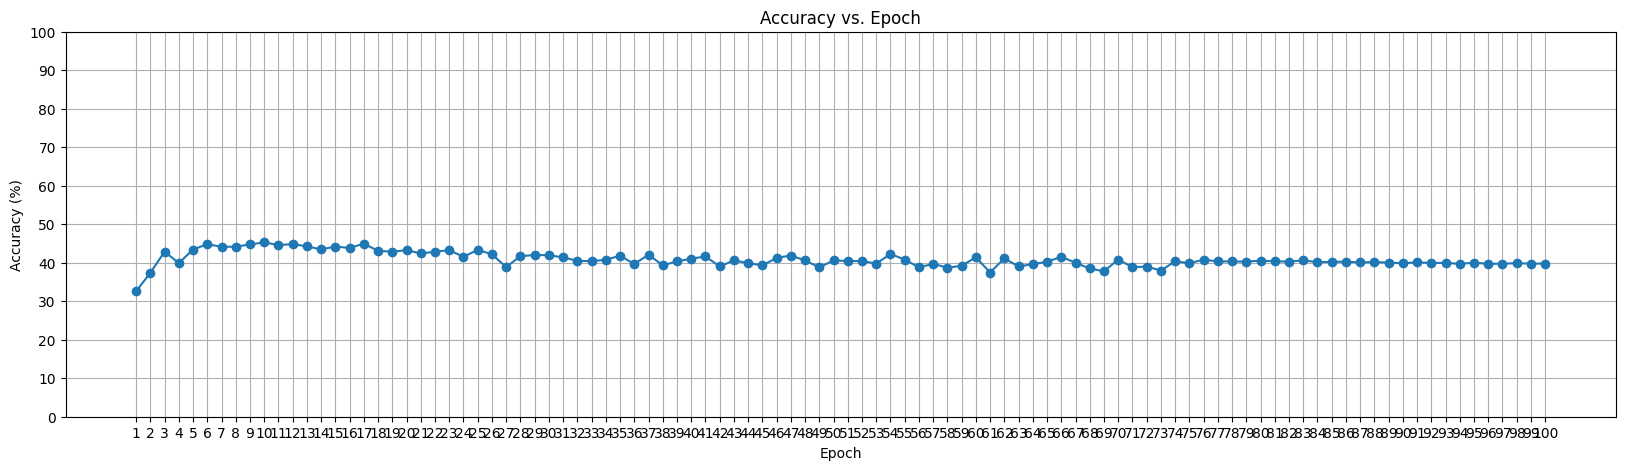

45.291666666666664

In [367]:
model_rnn=RNN(input_size,num_classes).to(device)
train_model(model_rnn, train_loader_rnn, test_loader_rnn, device) 
#50.17508754377189 entropy loss

In [368]:


# Assuming X_train.shape[1] is defined and device is defined
dummy_input = torch.zeros(1,1,X_train.shape[1]).to(device)  # Move dummy_input to the same device as the model
model_rnn.to(device)

# Visualize the model using torchviz
model_vis = make_dot(model_rnn(dummy_input), params=dict(model_rnn.named_parameters()))
model_vis.render("neural_network_visualization_secondary_rnn", format="png", view=True)

# Assuming num_classes is defined
summary(model_rnn, input_size=dummy_input.size()[1:])  # Correctly specifying input_size as a tuple


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 1, 512], [-1, 2, 512]]               0
            Linear-2                    [-1, 8]           4,104
Total params: 4,104
Trainable params: 4,104
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 4.00
Params size (MB): 0.02
Estimated Total Size (MB): 4.02
----------------------------------------------------------------


Epoch 1: Accuracy: 22.625%
Epoch 2: Accuracy: 24.416666666666668%
Epoch 3: Accuracy: 26.625%
Epoch 4: Accuracy: 29.541666666666668%
Epoch 5: Accuracy: 31.166666666666668%
Epoch 6: Accuracy: 31.583333333333332%
Epoch 7: Accuracy: 33.375%
Epoch 8: Accuracy: 37.041666666666664%
Epoch 9: Accuracy: 36.458333333333336%
Epoch 10: Accuracy: 38.0%
Epoch 11: Accuracy: 38.708333333333336%
Epoch 12: Accuracy: 37.541666666666664%
Epoch 13: Accuracy: 37.166666666666664%
Epoch 14: Accuracy: 38.708333333333336%
Epoch 15: Accuracy: 37.625%
Epoch 16: Accuracy: 38.166666666666664%
Epoch 17: Accuracy: 39.291666666666664%
Epoch 18: Accuracy: 38.75%
Epoch 19: Accuracy: 37.416666666666664%
Epoch 20: Accuracy: 38.166666666666664%
Epoch 21: Accuracy: 38.291666666666664%
Epoch 22: Accuracy: 35.833333333333336%
Epoch 23: Accuracy: 37.875%
Epoch 24: Accuracy: 35.625%
Epoch 25: Accuracy: 35.708333333333336%
Epoch 26: Accuracy: 36.291666666666664%
Epoch 27: Accuracy: 36.166666666666664%
Epoch 28: Accuracy: 35.375%


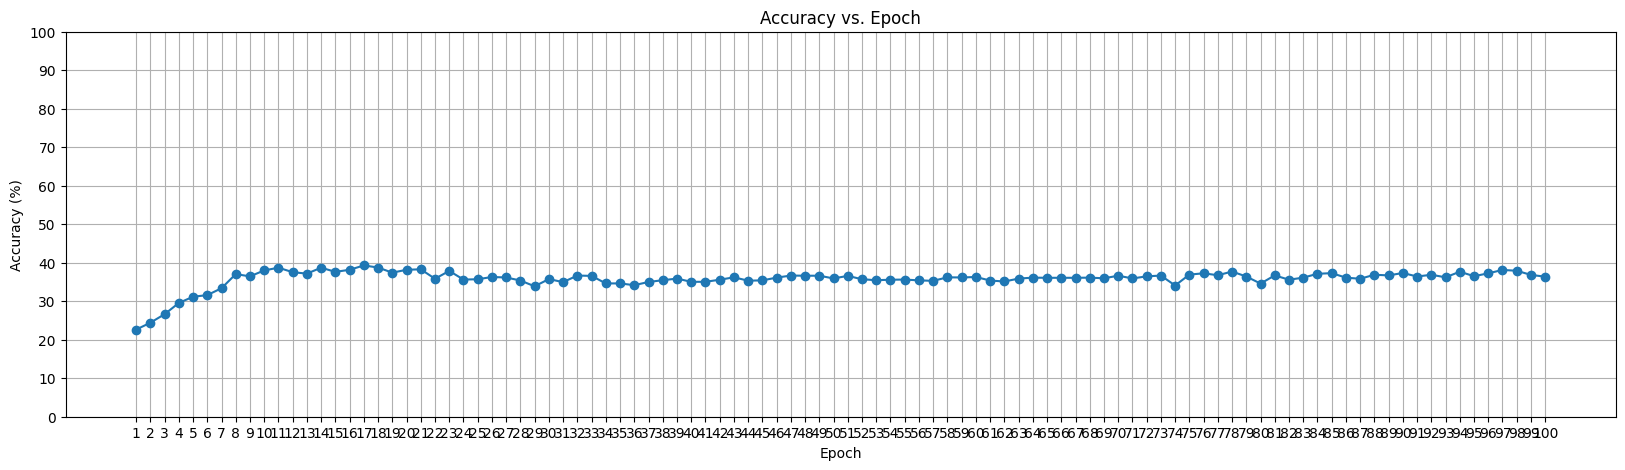

39.291666666666664

In [369]:
model_lstm=LSTM(input_size,num_classes).to(device)
train_model(model_lstm, train_loader_rnn, test_loader_rnn, device) 
#49.67483741870935 entropy loss

In [370]:


# # Assuming X_train.shape[1] is defined and device is defined
# dummy_input = torch.zeros(1,1,X_train.shape[1]).to(device)  # Move dummy_input to the same device as the model
# model_lstm.to(device)

# # Visualize the model using torchviz
# model_vis = make_dot(model_lstm(dummy_input), params=dict(model_lstm.named_parameters()))
# model_vis.render("neural_network_visualization_secondary_lstm", format="png", view=True)

# # Assuming num_classes is defined
# summary(model_lstm, input_size=dummy_input.size()[1:])  # Correctly specifying input_size as a tuple


Epoch 1: Accuracy: 33.791666666666664%
Epoch 2: Accuracy: 40.791666666666664%
Epoch 3: Accuracy: 41.416666666666664%
Epoch 4: Accuracy: 42.958333333333336%
Epoch 5: Accuracy: 44.75%
Epoch 6: Accuracy: 44.166666666666664%
Epoch 7: Accuracy: 45.125%
Epoch 8: Accuracy: 44.458333333333336%
Epoch 9: Accuracy: 44.083333333333336%
Epoch 10: Accuracy: 45.958333333333336%
Epoch 11: Accuracy: 44.75%
Epoch 12: Accuracy: 45.583333333333336%
Epoch 13: Accuracy: 45.0%
Epoch 14: Accuracy: 46.0%
Epoch 15: Accuracy: 44.708333333333336%
Epoch 16: Accuracy: 43.166666666666664%
Epoch 17: Accuracy: 43.166666666666664%
Epoch 18: Accuracy: 44.583333333333336%
Epoch 19: Accuracy: 43.458333333333336%
Epoch 20: Accuracy: 44.416666666666664%
Epoch 21: Accuracy: 42.75%
Epoch 22: Accuracy: 42.125%
Epoch 23: Accuracy: 43.791666666666664%
Epoch 24: Accuracy: 41.125%
Epoch 25: Accuracy: 43.5%
Epoch 26: Accuracy: 42.916666666666664%
Epoch 27: Accuracy: 40.583333333333336%
Epoch 28: Accuracy: 43.0%
Epoch 29: Accuracy: 

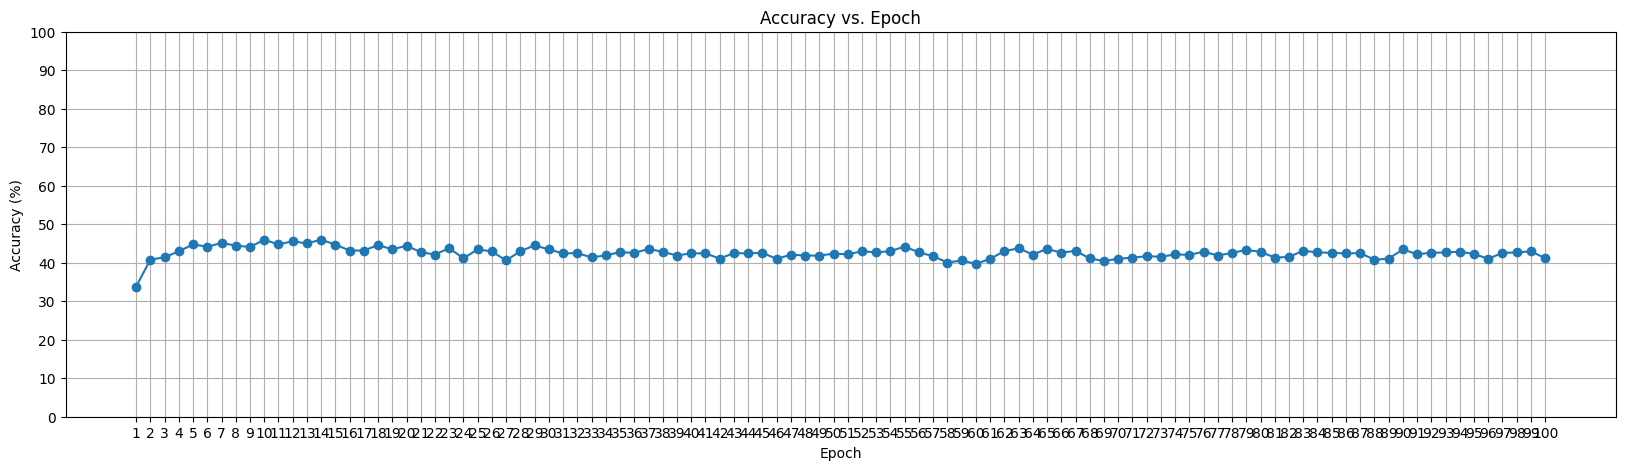

46.0

In [371]:
model_cnn_2=CNN1D(input_size,num_classes).to(device)
model_mlp_2=MLP(input_size,num_classes).to(device)
model_rnn_2=RNN(input_size,num_classes).to(device)
model_lstm_2=LSTM(input_size,num_classes).to(device)

model_ens=EnsembleModel(mlp=model_mlp_2,cnn=model_cnn_2,rnn=model_rnn_2,lstm=model_lstm_2,output_dim=num_classes).to(device)
train_model(model_ens, train_loader, test_loader, device)
# 53.62681340670335 accuracy entropy loss

In [372]:


# # Assuming X_train.shape[1] is defined and device is defined
# dummy_input = torch.zeros(1,X_train.shape[1]).to(device)  # Move dummy_input to the same device as the model
# model_ens.to(device)

# # Visualize the model using torchviz
# model_vis = make_dot(model_ens(dummy_input), params=dict(model_ens.named_parameters()))
# model_vis.render("neural_network_visualization_secondary_ens", format="png", view=True)

# # Assuming num_classes is defined
# summary(model_ens, input_size=(1,X_train.shape[1]))  # Correctly specifying input_size as a tuple


In [373]:
# Print model summary
model_summary(model_ens)

EnsembleModel(
  (mlp): MLP(
    (layers): Sequential(
      (0): BatchNorm1d(769, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=769, out_features=2048, bias=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=2048, out_features=1024, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Dropout(p=0.1, inplace=False)
      (7): Linear(in_features=1024, out_features=512, bias=True)
      (8): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): LeakyReLU(negative_slope=0.01)
      (10): Dropout(p=0.1, inplace=False)
      (11): Linear(in_features=512, out_features=256, bias=True)
      (12): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): LeakyReLU(negative_slope=0.01)
      (14): Linear(in_features=256, out_features=128, bias=True)
      (15): BatchNorm1d(128, eps=1e-05, momentum=

Other stuff

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import random

input_size = X_train.shape[1]
output_size = len(np.unique(y))

In [ ]:
import torch
from torch.utils.data import DataLoader

def train_model(model, optimizer, train_loader, test_loader, device, epochs=50):
    criterion = torch.nn.CrossEntropyLoss()  # Assuming classification task
    best_acc = 0
    best_epoch = 0
    
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        total_train = 0
        correct_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_train / total_train * 100
        
        # Validation phase
        model.eval()  # Set model to evaluate mode
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():  # No gradient calculation for validation
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(test_loader.dataset)
        val_accuracy = correct / total * 100
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {epoch_loss:.4f} - Train Acc: {epoch_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} - Val Acc: {val_accuracy:.2f}%')
        
        # Save the model if the validation accuracy is the best we've seen so far.
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pth')  # Save best model
            
    print(f'Best Validation Accuracy: {best_acc:.2f}% at Epoch {best_epoch+1}')
    return best_acc


In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR  # Learning rate scheduler

def train_model_best(model, optimizer, train_loader, test_loader, device, epochs=50):
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)  # Reduce LR every 30 epochs
    best_acc = 0
    best_epoch = 0
    patience = 10  # Early stopping patience
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_train = 0
        correct_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_train / total_train * 100

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(test_loader.dataset)
        val_accuracy = correct / total * 100

        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {epoch_loss:.4f} - Train Acc: {epoch_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} - Val Acc: {val_accuracy:.2f}%')

        # Learning rate scheduler step
        scheduler.step()

        # Early stopping check
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_epoch = epoch
            patience_counter = 0  # Reset counter
            torch.save(model.state_dict(), 'best_model.pth')  # Save best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Stopping early at epoch {epoch + 1}")
                break

    print(f'Best Validation Accuracy: {best_acc:.2f}% at Epoch {best_epoch+1}')
    return best_acc


In [ ]:


class NeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers, neurons_start, dropout_rate, use_bn, activation_fn):
        super(NeuralNet, self).__init__()
        layers = []

        # Calculate the decrement step to ensure the last layer has 64 neurons
        if neurons_start > 64:
            decrement = (neurons_start - 64) / (hidden_layers - 1)
        else:
            decrement = 0

        current_neurons = neurons_start

        for i in range(hidden_layers):
            next_neurons = max(64, int(current_neurons - decrement * i))  # Ensure we do not go below 64 neurons
            layers.append(nn.Linear(input_dim, next_neurons))
            if use_bn:
                layers.append(nn.BatchNorm1d(next_neurons))
            layers.append(activation_fn())
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            input_dim = next_neurons

        layers.append(nn.Linear(next_neurons, output_dim))  # Final layer to output
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [ ]:
params = {
    'num_layers': [2, 4, 6,8],  # Number of hidden layers
    'neurons_start': [256, 512, 1024,2048],  # Starting number of neurons
    'dropout_rate': [0.05, 0.1, 0.2],
    'batch_size': [64, 128, 256],
    'use_bn': [True, False],
    'learning_rate': [1e-2, 1e-3, 1e-4],
    'optimizer': [torch.optim.Adam, torch.optim.SGD],
    'activation_fn': [nn.ReLU, nn.LeakyReLU, nn.ELU],

}

# Random Search
num_searches = 256  # Number of random configurations to try
best_acc = 0
best_params = None
best_model = None

In [ ]:
for _ in range(num_searches):  # Number of configurations to try
    chosen_params = {k: random.choice(v) for k, v in params.items()}
    
    # Create model
    model = NeuralNet(input_size, num_classes, chosen_params['num_layers'], chosen_params['neurons_start'],
                      chosen_params['dropout_rate'], chosen_params['use_bn'], chosen_params['activation_fn']).to(device)
    
    # Setup optimizer
    optimizer = chosen_params['optimizer'](model.parameters(), lr=chosen_params['learning_rate'])
    
    # Train the model (function to be defined based on your setup)
    acc = train_model(model, optimizer, train_loader, test_loader, device)
    # acc= train_model_best(model, optimizer, train_loader, test_loader, device)
    # Track the best model
    if acc > best_acc:
        best_acc = acc
        best_params = chosen_params
        best_model = model_mlp

In [ ]:
print(f"Best Accuracy: {best_acc}")
print(f"Best Parameters: {best_params}")
# Best Accuracy: 54.17708854427213
# Best Parameters: {'num_layers': 4, 'neurons_start': 2048, 'dropout_rate': 0.1, 'batch_size': 128, 'use_bn': True, 'learning_rate': 0.0001, 'optimizer': <class 'torch.optim.adam.Adam'>, 'activation_fn': <class 'torch.nn.modules.activation.LeakyReLU'>}


In [ ]:
for _ in range(num_searches):  # Number of configurations to try
    chosen_params = {k: random.choice(v) for k, v in params.items()}
    
    # Create model
    model = NeuralNet(input_size, num_classes, chosen_params['num_layers'], chosen_params['neurons_start'],
                      chosen_params['dropout_rate'], chosen_params['use_bn'], chosen_params['activation_fn']).to(device)
    
    # Setup optimizer
    optimizer = chosen_params['optimizer'](model.parameters(), lr=chosen_params['learning_rate'])
    
    # Train the model (function to be defined based on your setup)
    # acc = train_model(model, optimizer, train_loader, test_loader, device)
    acc= train_model_best(model, optimizer, train_loader, test_loader, device)
    # Track the best model
    if acc > best_acc:
        best_acc = acc
        best_params = chosen_params
        best_model = model_mlp

In [ ]:

print(f"Best Accuracy: {best_acc}")
print(f"Best Parameters: {best_params}")

# Best Accuracy: 54.82741370685342
# Best Parameters: {'num_layers': 2, 'neurons_start': 512, 'dropout_rate': 0.1, 'batch_size': 64, 'use_bn': False, 'learning_rate': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>, 'activation_fn': <class 'torch.nn.modules.activation.LeakyReLU'>}


In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint

# # Setup the parameter grid
# param_dist_knn = {
#     'n_neighbors': randint(1, 30),  # Increased range for number of neighbors
#     'weights': ['uniform', 'distance'],  # Weight functions
#     'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],  # Distance metrics
#     'p': randint(1, 5)  # Power parameter for the Minkowski metric
# }
# # Initialize the KNN model
# knn = KNeighborsClassifier()

# # Setup RandomizedSearchCV
# random_search_knn = RandomizedSearchCV(knn, param_distributions=param_dist_knn, n_iter=25, cv=5, verbose=1, random_state=42, n_jobs=8)

# # Fit the model
# random_search_knn.fit(X_train, y_train)

# # Best parameters and score
# print("Best parameters found for KNN:", random_search_knn.best_params_)
# print("Best cross-validated score achieved for KNN:", random_search_knn.best_score_)


In [ ]:
from sklearn.metrics import accuracy_score

# Use the best estimator directly from the RandomizedSearchCV results for KNN
# best_knn = random_search_knn.best_estimator_
best_knn= {'metric': 'manhattan', 'n_neighbors': 8, 'p': 4, 'weights': 'distance'}


# Predict on the test set
y_pred_knn = best_knn.predict(X_test)

# Calculate accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Model Test Accuracy: {accuracy_knn * 100:.2f}%")


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# For KNN
print("KNN Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred_knn))
